In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from numpy import nan
import seaborn as sns
from sklearn import ensemble
import lightgbm as lgb
from sklearn.cross_validation import ShuffleSplit 
#from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV
path="/Users/xing/Desktop/test/"
filename=path+"full_train.csv"
Data= pd.read_csv(filename)

# label friaday and saturady, error go down 0.002
# string columns
string_cols = ['air_store_id', 'air_genre_name', 'air_area_name', 'hpg_genre_name', 'hpg_area_name',
               'area', 'city', 'street', 'area_genre', 'store_weekday', 
                'store_weekday_holiday',
              #  'store_week_of_year',        # this feature , error go down 0.001
            #   'store_month_of_year'        # this feature do not any improvence 
              ]

# Bool columns 
bool_cols = [ 'holiday_flg', 'tomorrow_is_holiday', 'yesterday_is_holiday']

# int columns
int_cols = ['weekday', 'year', 'month', 'day_of_year', 'days_in_month', 'week_of_year', 'days_since_startday',            'latitude_air', 'longitude_air',   # location
            'stores_same_street', 'stores_same_city', 'stores_same_area', 
            'reserves', 'reserve_visitors', 'reserve_avg_days_ahead',  # reserves
            'mean_visitors', 'median_visitors', 'min_visitors', 'max_visitors',  # simple aggregation of visitors
     #  'mean_week_visitors','median_week_visitors', 
  #   'min_week_visitors','max_week_visitors',         # those feature do not any help 
    #   'mean_month_visitors', 'median_month_visitors',   # those feature(week) cause overfit, error raise to 1.7, 3 times as orginal 
#   'min_month_visitors', 'max_month_visitors',    # do any improve, although error keep close the same
           ]

# id columns
id_col = 'id'

# target column
target_col = 'visitors'

#implement  lable encode, so that we can deal with our data using xgboost

#conve string data into number by lable encode
for str_encode in string_cols:
    encoder = LabelEncoder()
    Data[str_encode] = encoder.fit_transform(Data[str_encode].astype(str))
Data[string_cols].head()

FullData = Data.query('dataset=="past"')
future  = Data.query('dataset=="predict"')

FullData.head()

use_cols = string_cols + bool_cols + int_cols

# train data
train_date = FullData.visit_date < '2017-03-1'
X_train = FullData[train_date][use_cols]
y_train = FullData[train_date][target_col].apply(np.log1p)

#test data
val_date = FullData.visit_date >= '2017-03-1'
X_test = FullData[val_date][use_cols]
y_test = FullData[val_date][target_col].apply(np.log1p)


FullData[use_cols].head()

X = np.nan_to_num(X_train)
y = np.nan_to_num(y_train)
'''
def  BestIteration(params,jobs):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2)
    classifier = GridSearchCV(estimator=estimator, verbose=1, param_grid=params, n_jobs=4)
    classifier.fit(X, y)
    return  classifier.best_estimator_

# gradient boosting train and fit
params = {'n_estimators': [100,200,500,1000], 'max_depth': [2,4,6,8], 'min_samples_split': [1,2,4,8],
          'learning_rate': [0.01,0.02,0.05,0.1]}
print BestIteration(params,4)
'''

params = {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 4,
          'learning_rate': 0.005, 'loss':'ls'}

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X, y)
# Plot feature importance
feature_importance = clf.feature_importances_

x_predict=np.nan_to_num(future[use_cols])
future[target_col] = clf.predict(x_predict)
future[target_col] = future[target_col].apply(np.expm1).clip(lower=0.)
sub = future[[id_col, target_col]].copy()
sub.to_csv(path+'submission_grad.csv', index=False)
sub.head()

"clf = ensemble.GradientBoostingRegressor(**params)\n#X = np.nan_to_num(X_train)\n#y = np.nan_to_num(y_train)\nclf.fit(X, y)\n# Plot feature importance\nfeature_importance = clf.feature_importances_\n\n# predict , the public score is 0.499 \nx_predict=np.nan_to_num(future[use_cols])\nfuture[target_col] = clf.predict(x_predict)\nfuture[target_col] = future[target_col].apply(np.expm1).clip(lower=0.)\nsub = future[[id_col, target_col]].copy()\nsub.to_csv(path+'submission_grad.csv', index=False)\nsub.head()"

[1]	valid_0's rmse: 0.830869
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.827318
[3]	valid_0's rmse: 0.823665
[4]	valid_0's rmse: 0.820586
[5]	valid_0's rmse: 0.817074
[6]	valid_0's rmse: 0.813606
[7]	valid_0's rmse: 0.810143
[8]	valid_0's rmse: 0.806726
[9]	valid_0's rmse: 0.803419
[10]	valid_0's rmse: 0.800036
Did not meet early stopping. Best iteration is:
[10]	valid_0's rmse: 0.800036
start predicting.........


/Users/xing/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xing/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Plot feature importances...


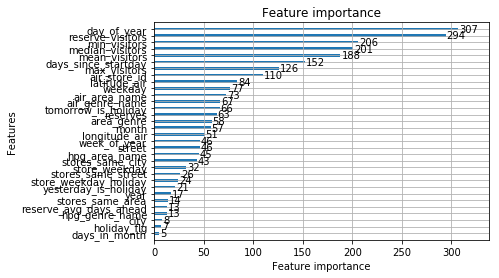

In [30]:
from numpy import nan
import seaborn as sns
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
                'num_leaves': 2 ** 8 - 1,
                'objective': 'regression_l2',
                'max_depth': 9,
                'min_data_in_leaf': 50,
                'learning_rate': 0.007,
                'feature_fraction': 0.6,
                'bagging_fraction': 0.8,
                'bagging_freq': 1,
                'metric': 'rmse',
                'num_threads': 4,
                'seed': 2018,
            }
gbm = lgb.train(params, lgb_train,
                num_boost_round=10, valid_sets=lgb_eval,
                early_stopping_rounds=5)
print 'start predicting.........'
future[target_col] = gbm.predict(future[use_cols], num_iteration=gbm.best_iteration)
future[target_col] = future[target_col].apply(np.expm1).clip(lower=0.)
sub = future[[id_col, target_col]].copy()
sub.to_csv(path+'submission_lightgbm.csv', index=False)
sub.head()

#plot feature importance
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=40,height=0.4)
plt.show()
